Proposal codes

In [6]:
library(tidyverse)
library(readxl)
library(ggplot2)
library(gridExtra)
library(repr)
#install.packages("psych")
#library(psych)
library(GGally)
library(tidymodels)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ gridExtra::combine() masks dplyr::combine()
✖ scales::discard()    masks purrr::discard()
✖ dplyr::filter()      masks stats::filter()
✖ recipes::fixed()     masks stringr::fixed()
✖ dplyr::lag()         masks stats::lag()
✖ yardstick::spec()    masks readr::spec()
✖ recipes::step()      masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org



In [8]:
# show data can be read
options(repr.plot.width = 15, repr.plot.height = 10)

train_data <- read_csv("https://raw.githubusercontent.com/fyang1419/group-56-project/main/train_data.csv") |>
select(STG:UNS)

test_data <- read_csv("https://raw.githubusercontent.com/fyang1419/group-56-project/main/test_data.csv") |>
select(STG:UNS)


#tidy data: turn UNS into factors in both sets of data, then turn to numeric levels starting at 1 for very_low
#clean and wrangle data
train_data <- train_data |>
mutate(UNS = factor(UNS, levels=c('very_low','Low','Middle','High')))

test_data <- test_data |>
mutate(UNS = factor(UNS, levels=c('very_low','Low','Middle','High')))

#turn class levels to 1,2,3,4 (very low, low, middle, high)
#train_data_cleaned<- train_data |>
#mutate(UNS = as.factor(UNS))
#mutate(UNS = as.numeric(UNS)) 

#test_data_cleaned <- test_data |>
#mutate(UNS = factor(as.factor(UNS), levels=(rev(levels(as.factor(UNS)))))) |>
#mutate(UNS = as.factor(as.numeric(UNS)))

#class(train_data_cleaned$UNS)
#head(train_data)
#head(train_data_cleaned)

New names:
• `` -> `...1`
• `...7` -> `...8`
• `...8` -> `...9`
Rows: 258 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (6): ...1, STG, SCG, STR, LPR, PEG
lgl (2): ...8, ...9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
• `...7` -> `...8`
• `...8` -> `...9`
Rows: 145 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (6): ...1, STG, SCG, STR, LPR, PEG
lgl (2): ...8, ...9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
#Summary table for predictors in train-data
summary_pred_train <- describe(train_data[-6], fast=TRUE)
summary_pred_train

In [ ]:
#visualizing training data (histogram)
# plots showing distribution of each predictor: 

prawSTG <- ggplot(train_data, aes(STG))+
geom_histogram(colour="black", fill="lightblue", bins=30)

prawSCG <- ggplot(train_data, aes(SCG))+
geom_histogram(colour="black", fill="lightblue")

prawSTR <- ggplot(train_data, aes(STR))+
geom_histogram(colour="black", fill="lightblue")

prawLPR <- ggplot(train_data, aes(LPR))+
geom_histogram(colour="black", fill="lightblue")

prawPEG <- ggplot(train_data, aes(PEG))+
geom_histogram(colour="black", fill="lightblue")

grid.arrange(prawSTG, prawSCG, prawSTR, prawLPR, prawPEG, ncol=3, top="Distribution of predictors")


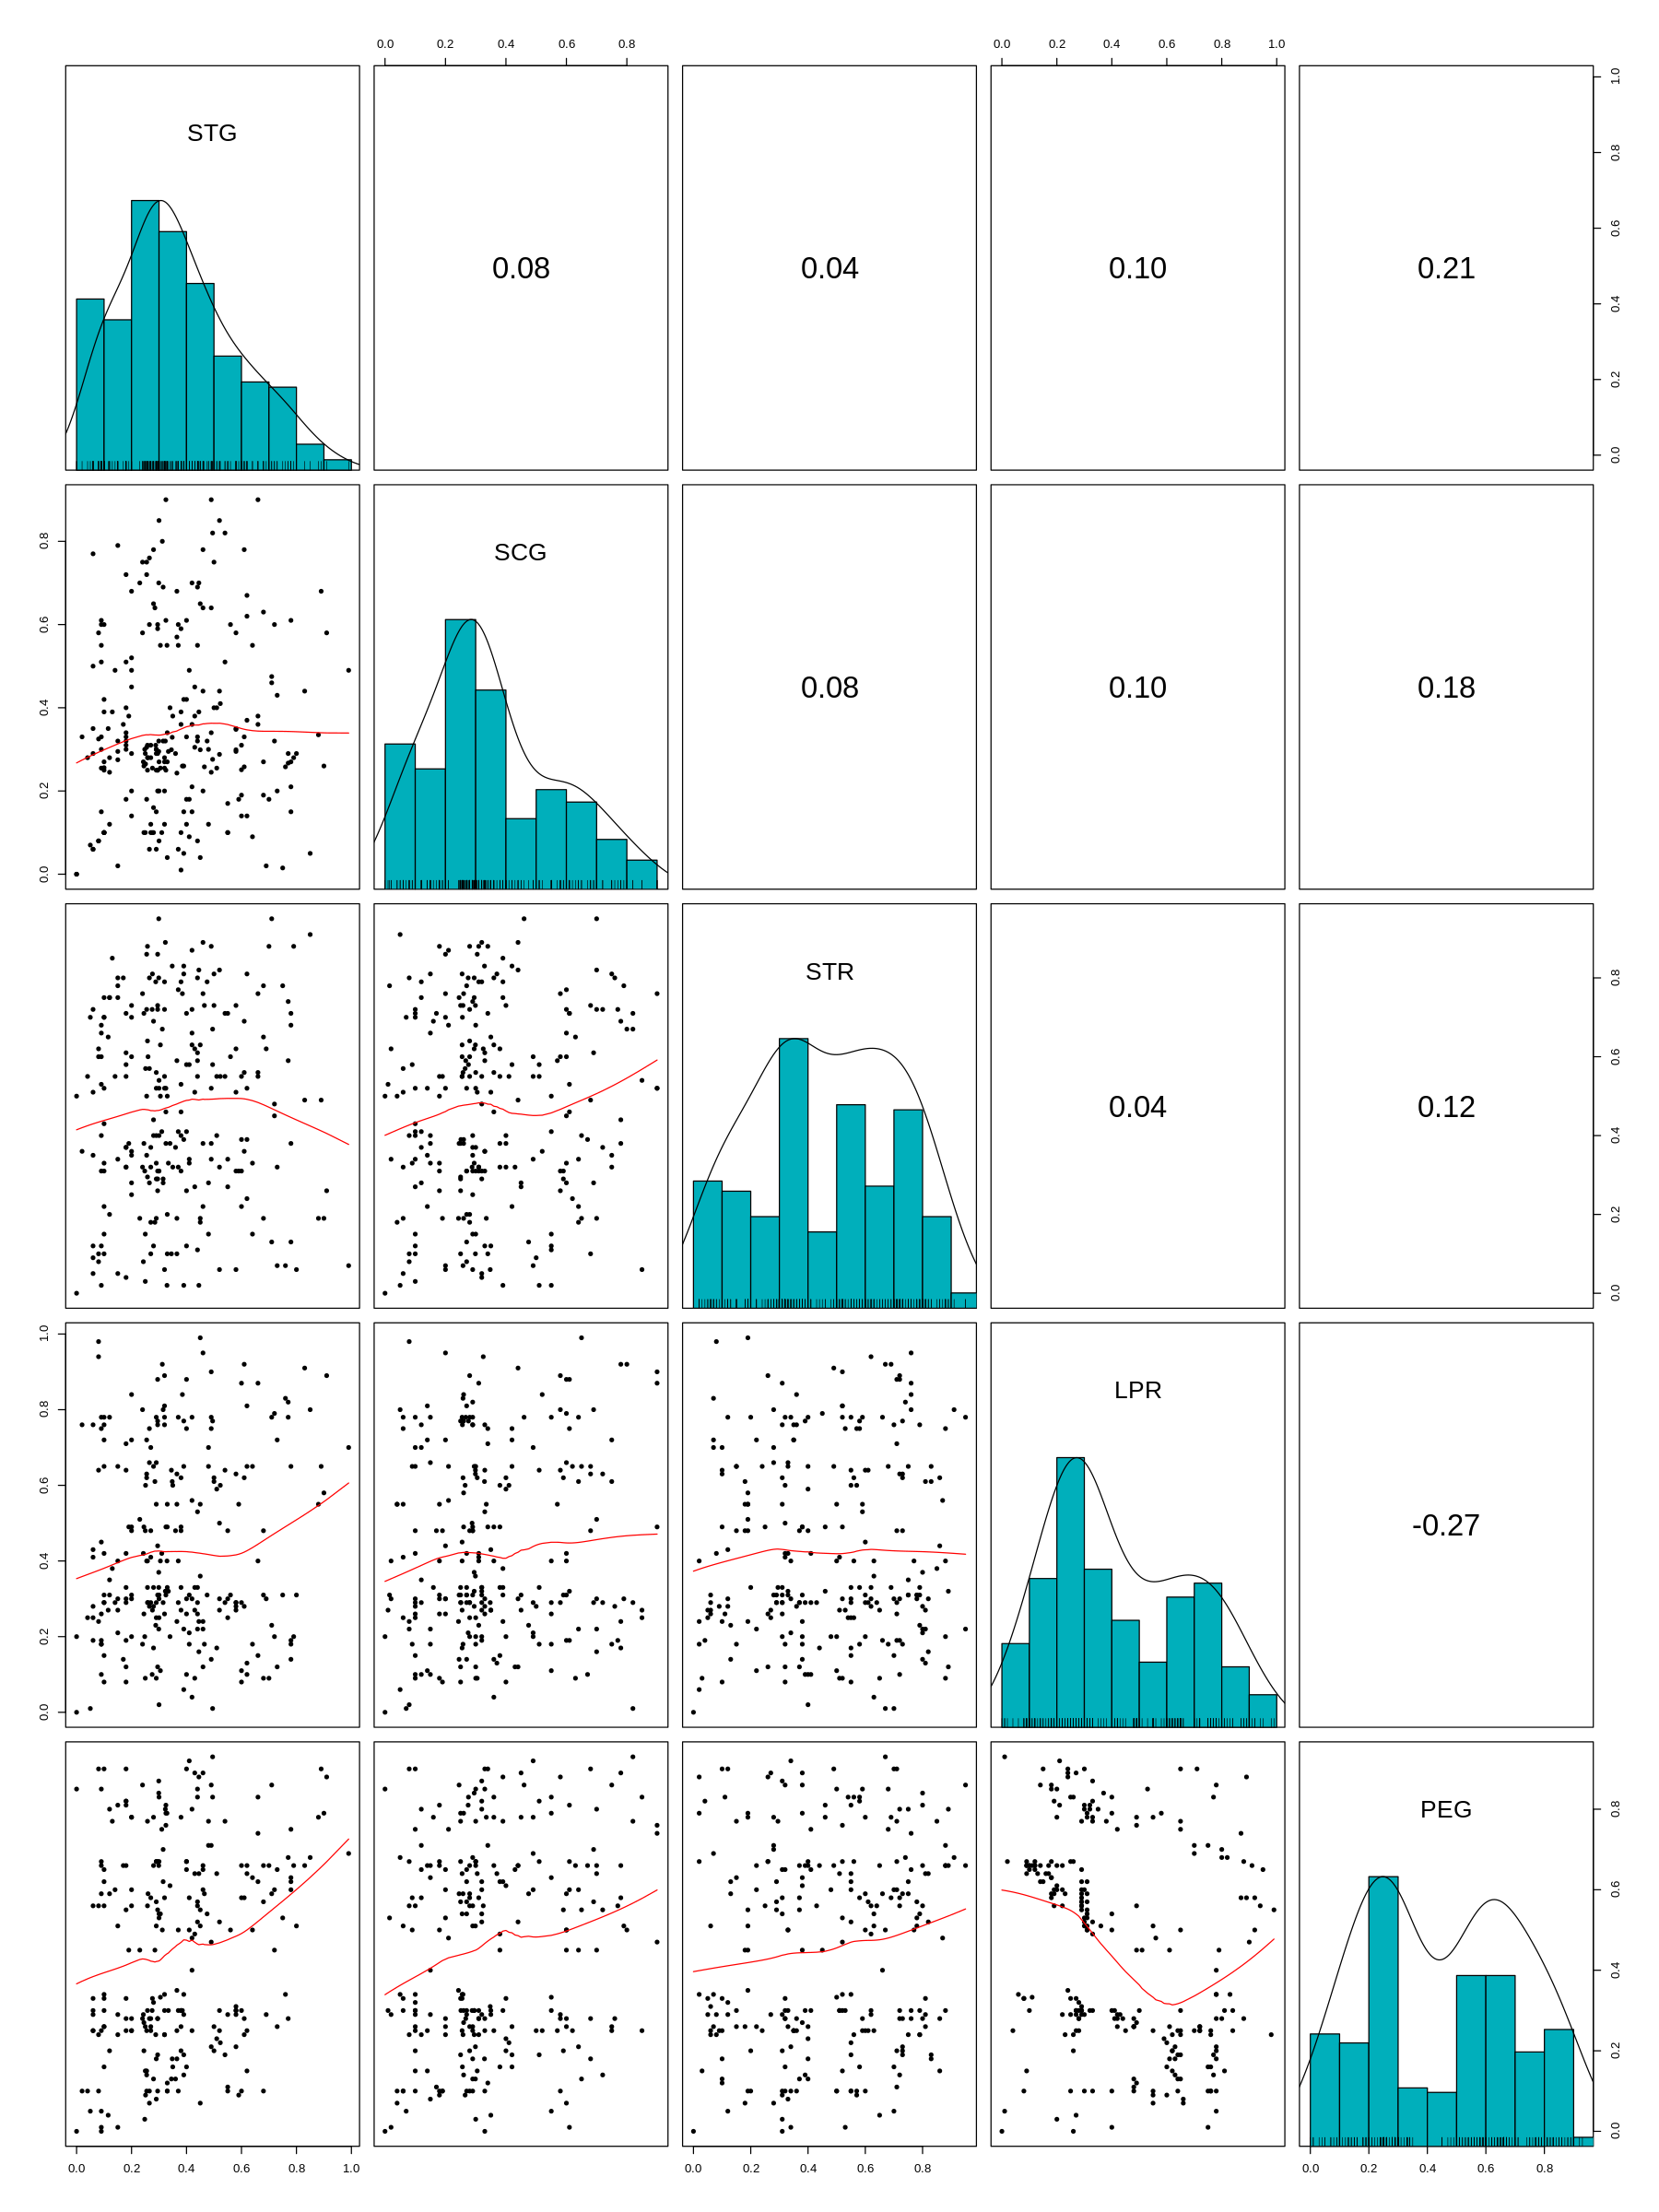

In [35]:
pairs.panels(train_data[,-6], 
             method = "pearson", # correlation method
             hist.col = "#00AFBB",
             density = TRUE,  # show density plots
             ellipses = FALSE # show correlation ellipses
             )

Warning message in warn_if_args_exist(list(...)):
“Extra arguments: 'colums' are being ignored.  If these are meant to be aesthetics, submit them using the 'mapping' variable within ggpairs with ggplot2::aes or ggplot2::aes_string.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



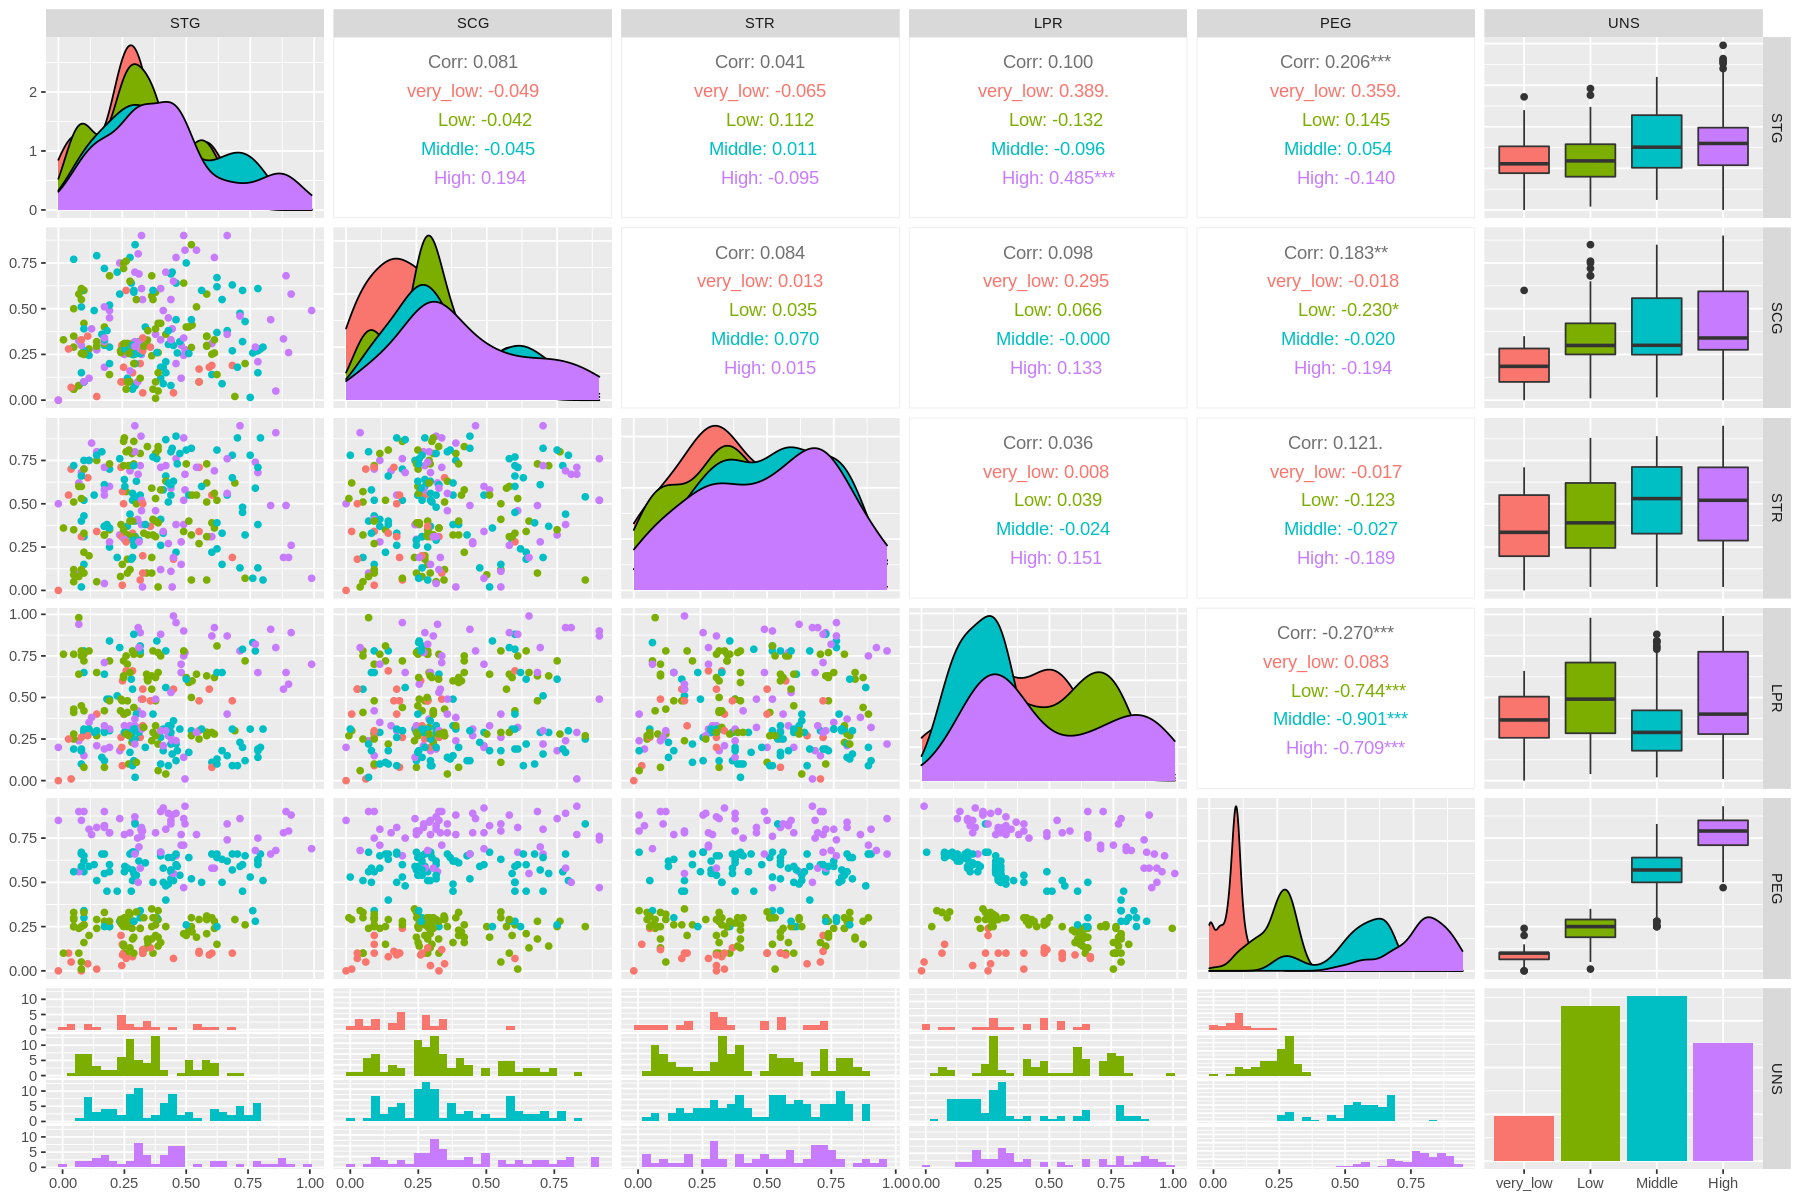

In [11]:

ggpairs(train_data, colums=1:5, aes(color=UNS))
        

In [37]:
set.seed(1)
vfold <- vfold_cv(train_data, v = 5, strata = UNS)

recipe <- recipe(UNS ~ STG+STR+PEG, data = train_data) |> 
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 5)) 

knn_results <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = vfold, grid = gridvals) |>
  collect_metrics() 
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6748869,5,0.03633795,Preprocessor1_Model01
6,accuracy,multiclass,0.7527149,5,0.04548524,Preprocessor1_Model02
11,accuracy,multiclass,0.7484917,5,0.03331144,Preprocessor1_Model03
16,accuracy,multiclass,0.7446456,5,0.03293269,Preprocessor1_Model04
21,accuracy,multiclass,0.7408748,5,0.04647937,Preprocessor1_Model05
26,accuracy,multiclass,0.7447964,5,0.04299096,Preprocessor1_Model06
31,accuracy,multiclass,0.7292609,5,0.03778875,Preprocessor1_Model07
36,accuracy,multiclass,0.6981146,5,0.02795173,Preprocessor1_Model08
41,accuracy,multiclass,0.6631976,5,0.02984711,Preprocessor1_Model09


In [40]:
gridvals2 <- tibble(neighbors = seq(from = 1, to = 20, by = 1)) 

knn_results2 <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = vfold, grid = gridvals2) |>
  collect_metrics() 
accuracies2 <- knn_results2 |>
  filter(.metric == "accuracy")

accuracies2

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6748869,5,0.03633795,Preprocessor1_Model01
2,accuracy,multiclass,0.6748869,5,0.03633795,Preprocessor1_Model02
3,accuracy,multiclass,0.7175716,5,0.03497409,Preprocessor1_Model03
4,accuracy,multiclass,0.7097285,5,0.03137708,Preprocessor1_Model04
5,accuracy,multiclass,0.7448718,5,0.04027453,Preprocessor1_Model05
6,accuracy,multiclass,0.7527149,5,0.04548524,Preprocessor1_Model06
7,accuracy,multiclass,0.7332579,5,0.04905956,Preprocessor1_Model07
8,accuracy,multiclass,0.7371041,5,0.04724337,Preprocessor1_Model08
9,accuracy,multiclass,0.7214178,5,0.03562608,Preprocessor1_Model09


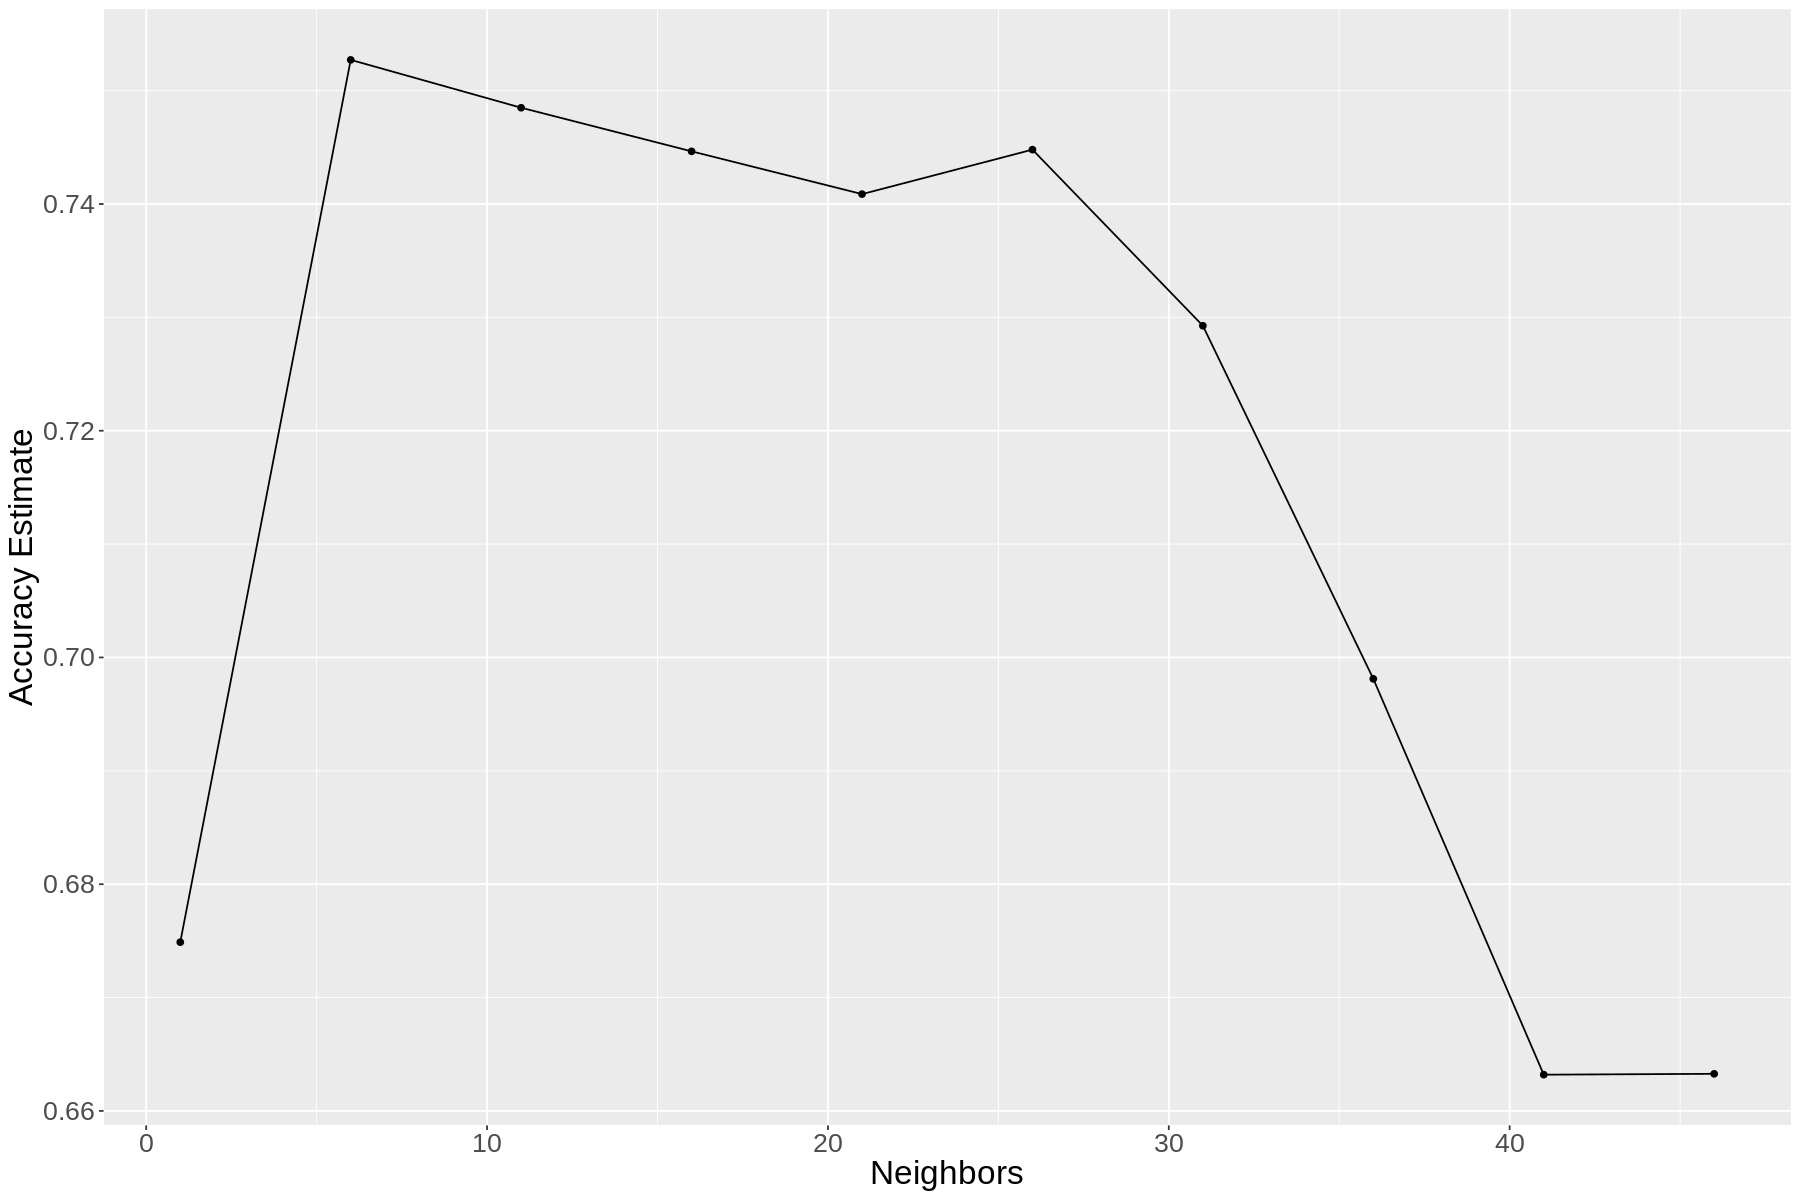

In [42]:
# Plot k values against their respective accuracies and choose optimal k value
cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))
cross_val_plot

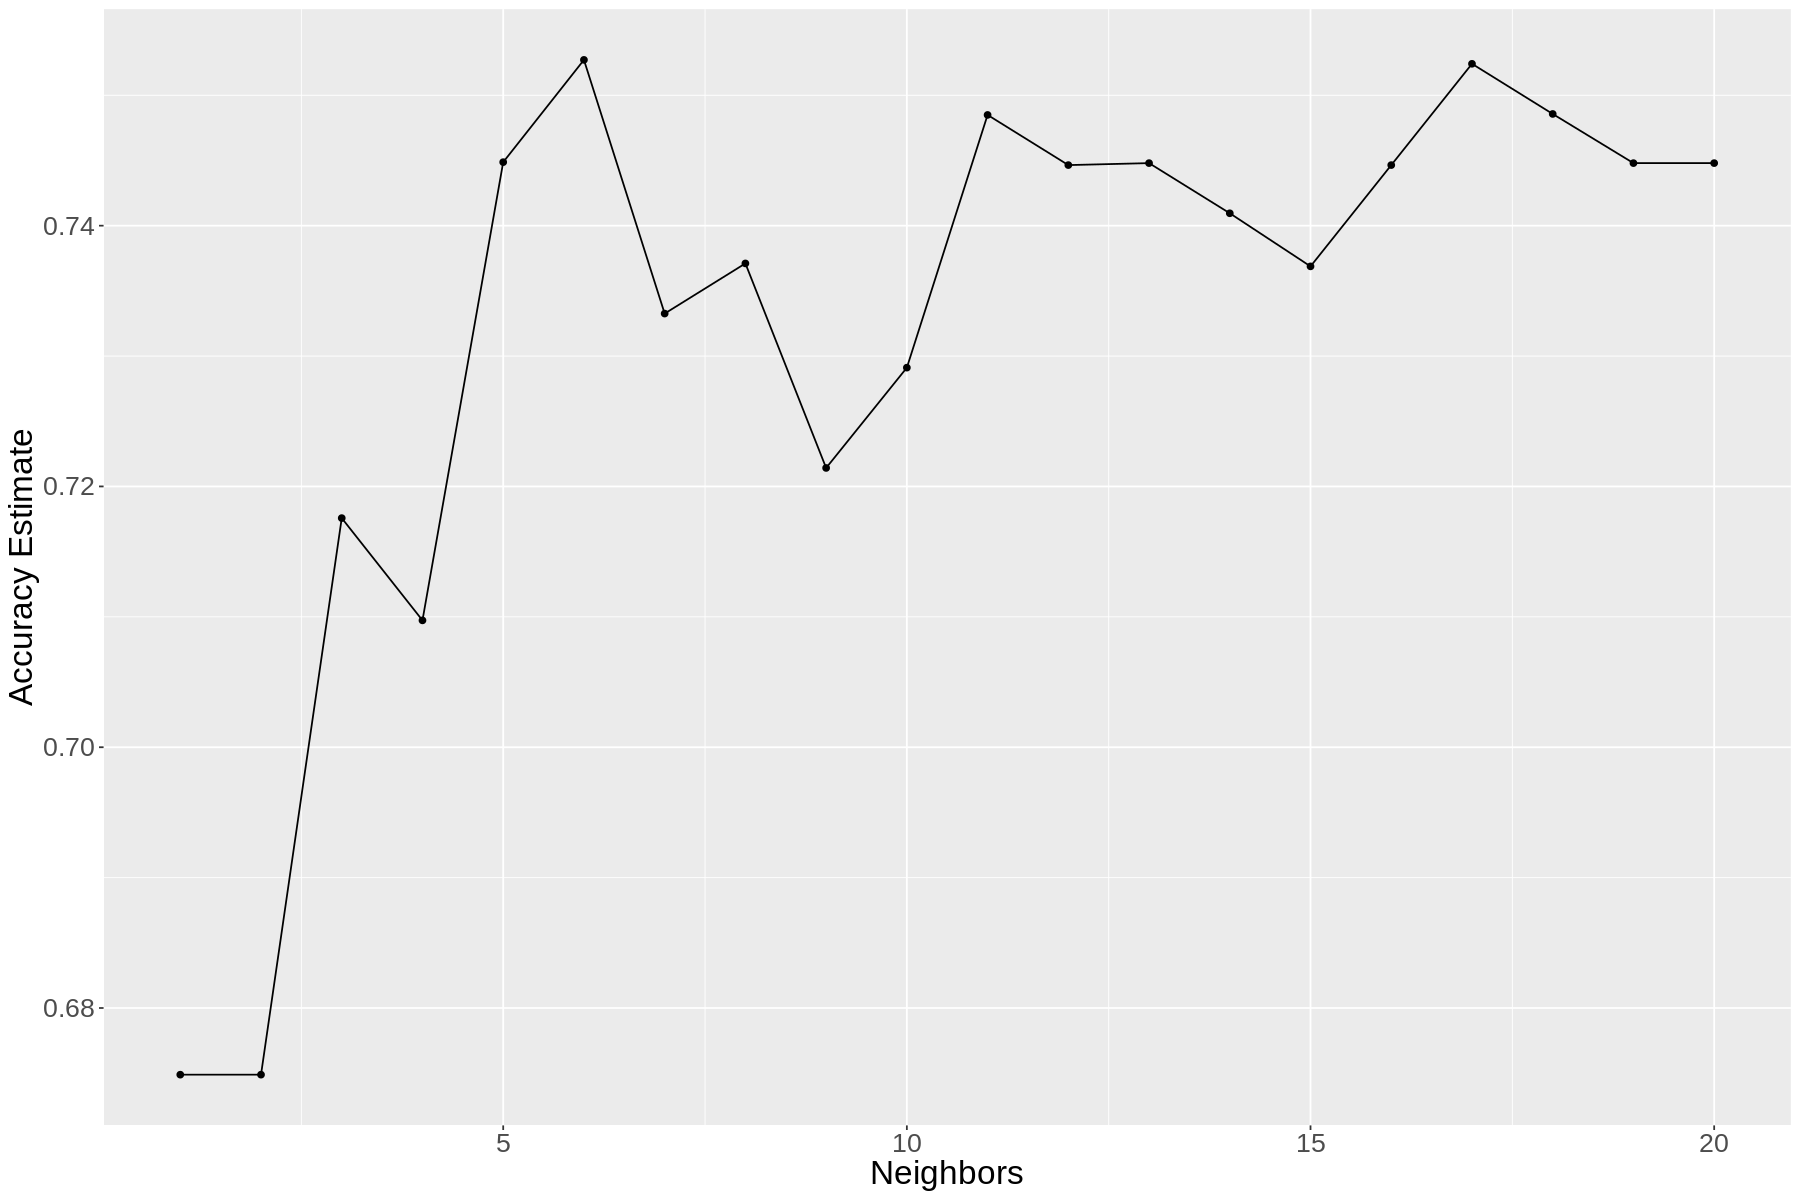

In [43]:
# Plot k values against their respective accuracies and choose optimal k value
cross_val_plot <- accuracies2 |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))
cross_val_plot